# **Transfer Learning With Resnet-50 Model (Binary Classification)**

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"anjumzahid","key":"f12ac7d8a901a1002dcd742df3f05872"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 801M/812M [00:05<00:00, 175MB/s]
100% 812M/812M [00:05<00:00, 153MB/s]


In [ ]:
!ls


In [ ]:
import zipfile
import os

with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
import os

# Path to the extracted 'data' folder
nested_zip_path = 'data'

# Extract each nested zip file
for file in os.listdir(nested_zip_path):
    if file.endswith('.zip'):
        file_path = os.path.join(nested_zip_path, file)
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            extract_dir = os.path.join(nested_zip_path, file.replace('.zip', ''))  # Create sub-folder
            zip_ref.extractall(extract_dir)  # Extract into a folder named after the zip file


In [ ]:
import os
import shutil

# Paths to your 'train' directory and subdirectories
train_dir = '/content/data/train/train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# Create 'cat' and 'dog' subdirectories if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move the cat images into the 'cat' folder
for file in os.listdir(train_dir):
    # Make sure we are not trying to move directories
    if file.endswith('.jpg'):
        if file.startswith('cat'):
            shutil.move(os.path.join(train_dir, file), os.path.join(cat_dir, file))

# Move the dog images into the 'dog' folder
for file in os.listdir(train_dir):
    # Make sure we are not trying to move directories
    if file.endswith('.jpg'):
        if file.startswith('dog'):
            shutil.move(os.path.join(train_dir, file), os.path.join(dog_dir, file))



In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/data/train/train',  # Path to your dataset
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/data/train/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Apply ResNet50's specific preprocessing
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))


# **Base Model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import numpy as np
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global pooling layer and output layer to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model_base = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers (base model + new layers)
for layer in model_base.layers:
    layer.trainable = False

# Compile the model
model_base.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Evaluate the model on both training and validation sets
train_loss, train_acc = model_base.evaluate( train_ds, verbose=1)
val_loss, val_acc = model_base.evaluate(val_ds, verbose=1)

print(f"Training Data Loss: {train_loss:.4f}, Training Data Accuracy: {train_acc:.4f}")
print(f"Validation Data Loss: {val_loss:.4f}, Validation Data Accuracy: {val_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.3870 - loss: 0.8749
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.3840 - loss: 0.8770
Training Data Loss: 0.8716, Training Data Accuracy: 0.3892
Validation Data Loss: 0.8724, Validation Data Accuracy: 0.3874


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Get true classes and predicted probabilities for the validation dataset
val_true_classes = []  # True labels
val_predictions_prob = []  # Predicted probabilities

# Loop through validation dataset to collect predictions
for x, y in val_ds:
    val_true_classes.extend(y.numpy())
    val_predictions_prob.extend(model_base.predict(x).flatten())  # Flatten to ensure 1D array

# Convert probabilities to binary predictions
val_predictions_classes = [1 if prob > 0.5 else 0 for prob in val_predictions_prob]

# Calculate precision and recall
precision = precision_score(val_true_classes, val_predictions_classes)
recall = recall_score(val_true_classes, val_predictions_classes)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
# print("--" * 30)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━

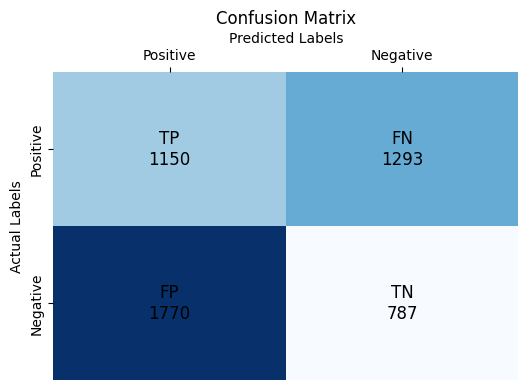

In [ ]:
# Calculate confusion matrix
confusion = confusion_matrix(val_true_classes, val_predictions_classes)

# Visualize confusion matrix with TP, TN, FP, FN labels
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=False, cmap='Blues',
            xticklabels=['Positive', 'Negative'],  # Predicted classes: Positive left, Negative right
            yticklabels=['Positive', 'Negative'],  # Actual classes: Positive top, Negative below
            cbar=False)

# Add text annotations for TP, FP, FN, TN
labels = [["TP", "FN"], ["FP", "TN"]]  # Corrected labels for confusion matrix
for i in range(2):
    for j in range(2):
        value = confusion[i, j]
        label = labels[i][j]
        plt.text(j + 0.5, i + 0.5, f"{label}\n{value}",
                 ha='center', va='center', color="black", fontsize=12)


# Adjust layout
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

# Move x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.show()

# **Optimized Model-1**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  # Dropout with a rate of 50%

predictions = Dense(1, activation='sigmoid')(x)

model_op = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False


# Unfreeze the last 30 layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# # Compile the model

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_op.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Step 4: Train your model with augmented dataset
model_op.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 372ms/step - accuracy: 0.9192 - loss: 0.1845 - val_accuracy: 0.9860 - val_loss: 0.0410
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 299ms/step - accuracy: 0.9876 - loss: 0.0351 - val_accuracy: 0.9872 - val_loss: 0.0350
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 297ms/step - accuracy: 0.9888 - loss: 0.0301 - val_accuracy: 0.9884 - val_loss: 0.0329
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 290ms/step - accuracy: 0.9912 - loss: 0.0264 - val_accuracy: 0.9878 - val_loss: 0.0320
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 282ms/step - accuracy: 0.9923 - loss: 0.0221 - val_accuracy: 0.9880 - val_loss: 0.0320
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 287ms/step - accuracy: 0.9934 - loss: 0.0193 - val_accuracy: 0.9870 - val_loss: 0.0322
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 289ms/step - accuracy: 0.9935 - loss: 0.0182 - val_accuracy: 0.9866 - val_loss: 0.0320
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 284ms/step - accuracy: 0.9939 - loss:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Evaluate the optimized model on the validation dataset
val_true_classes_op = []  # True labels for optimized model
val_predictions_prob_op = []  # Predicted probabilities for optimized model

# Loop through validation dataset to collect predictions
for x, y in val_ds:
    val_true_classes_op.extend(y.numpy())
    val_predictions_prob_op.extend(model_op.predict(x, verbose=0).flatten())  # Suppress logs with verbose=0

# Convert probabilities to binary predictions
val_predictions_classes_op = [1 if prob > 0.5 else 0 for prob in val_predictions_prob_op]

# Calculate precision and recall for the optimized model
precision_op = precision_score(val_true_classes_op, val_predictions_classes_op)
recall_op = recall_score(val_true_classes_op, val_predictions_classes_op)

# Print precision and recall for the optimized model
print(f'Precision (Optimized Model): {precision_op:.2f}')
print(f'Recall (Optimized Model): {recall_op:.2f}')

Precision (Optimized Model): 0.99
Recall (Optimized Model): 0.98


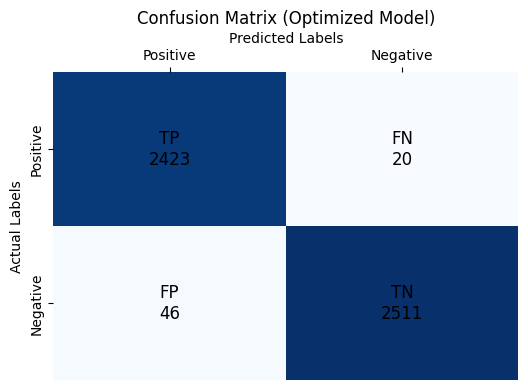

In [ ]:
# Calculate confusion matrix for the optimized model
confusion_op = confusion_matrix(val_true_classes_op, val_predictions_classes_op)

# Visualize confusion matrix with TP, TN, FP, FN labels
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_op, annot=False, cmap='Blues',
            xticklabels=['Positive', 'Negative'],  # Predicted classes: Positive left, Negative right
            yticklabels=['Positive', 'Negative'],  # Actual classes: Positive top, Negative below
            cbar=False)

# Add text annotations for TP, FP, FN, TN
labels = [["TP", "FN"], ["FP", "TN"]]  # Corrected confusion matrix labels
for i in range(2):
    for j in range(2):
        value = confusion_op[i, j]
        label = labels[i][j]
        plt.text(j + 0.5, i + 0.5, f"{label}\n{value}",
                 ha='center', va='center', color="black", fontsize=12)

# Adjust layout
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

# Move x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.show()

# **Optimized Model-2**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  # Dropout with a rate of 50%

predictions = Dense(1, activation='sigmoid')(x)

model_op3 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False


# Unfreeze the last 30 layers
for layer in base_model.layers[-25:]:
    layer.trainable = True

# # Compile the model

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_op3.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Step 4: Train your model
model_op3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 335ms/step - accuracy: 0.9216 - loss: 0.1910 - val_accuracy: 0.9858 - val_loss: 0.0392
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 295ms/step - accuracy: 0.9893 - loss: 0.0315 - val_accuracy: 0.9852 - val_loss: 0.0378
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9870 - val_loss: 0.0352
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 302ms/step - accuracy: 0.9966 - loss: 0.0118 - val_accuracy: 0.9884 - val_loss: 0.0335
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 304ms/step - accuracy: 0.9984 - loss: 0.0071 - val_accuracy: 0.9878 - val_loss: 0.0364
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 309ms/step - accuracy: 0.9987 - loss: 0.0071 - val_accuracy: 0.9882 - val_loss: 0.0351
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 306ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9878 - val_loss: 0.0362
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 312ms/step - accuracy: 0.9995 - los

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Evaluate the optimized model on the validation dataset
val_true_classes_op3 = []  # True labels for optimized model
val_predictions_prob_op3 = []  # Predicted probabilities for optimized model

# Loop through validation dataset to collect predictions
for x, y in val_ds:
    val_true_classes_op3.extend(y.numpy())
    val_predictions_prob_op3.extend(model_op3.predict(x, verbose=0).flatten())  # Suppress logs with verbose=0

# Convert probabilities to binary predictions
val_predictions_classes_op3 = [1 if prob > 0.5 else 0 for prob in val_predictions_prob_op3]

# Calculate precision and recall for the optimized model
precision_op3 = precision_score(val_true_classes_op3, val_predictions_classes_op3)
recall_op3 = recall_score(val_true_classes_op3, val_predictions_classes_op3)

# Print precision and recall for the optimized model
print(f'Precision (Optimized Model): {precision_op3:.2f}')
print(f'Recall (Optimized Model): {recall_op3:.2f}')

Precision (Optimized Model): 0.99
Recall (Optimized Model): 0.99


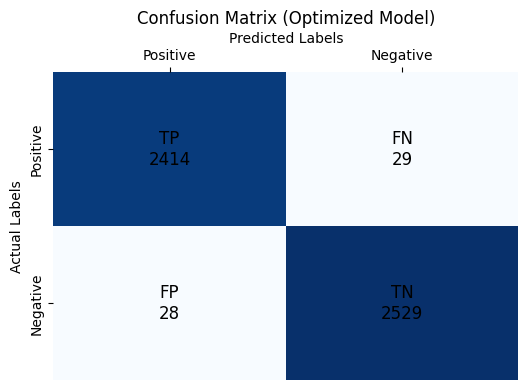

In [ ]:
# Calculate confusion matrix for the optimized model
confusion_op3 = confusion_matrix(val_true_classes_op3, val_predictions_classes_op3)

# Visualize confusion matrix with TP, TN, FP, FN labels
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_op3, annot=False, cmap='Blues',
            xticklabels=['Positive', 'Negative'],  # Predicted classes: Positive left, Negative right
            yticklabels=['Positive', 'Negative'],  # Actual classes: Positive top, Negative below
            cbar=False)

# Add text annotations for TP, FP, FN, TN
labels = [["TP", "FN"], ["FP", "TN"]]  # Corrected confusion matrix labels
for i in range(2):
    for j in range(2):
        value = confusion_op3[i, j]
        label = labels[i][j]
        plt.text(j + 0.5, i + 0.5, f"{label}\n{value}",
                 ha='center', va='center', color="black", fontsize=12)

# Adjust layout
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

# Move x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.show()

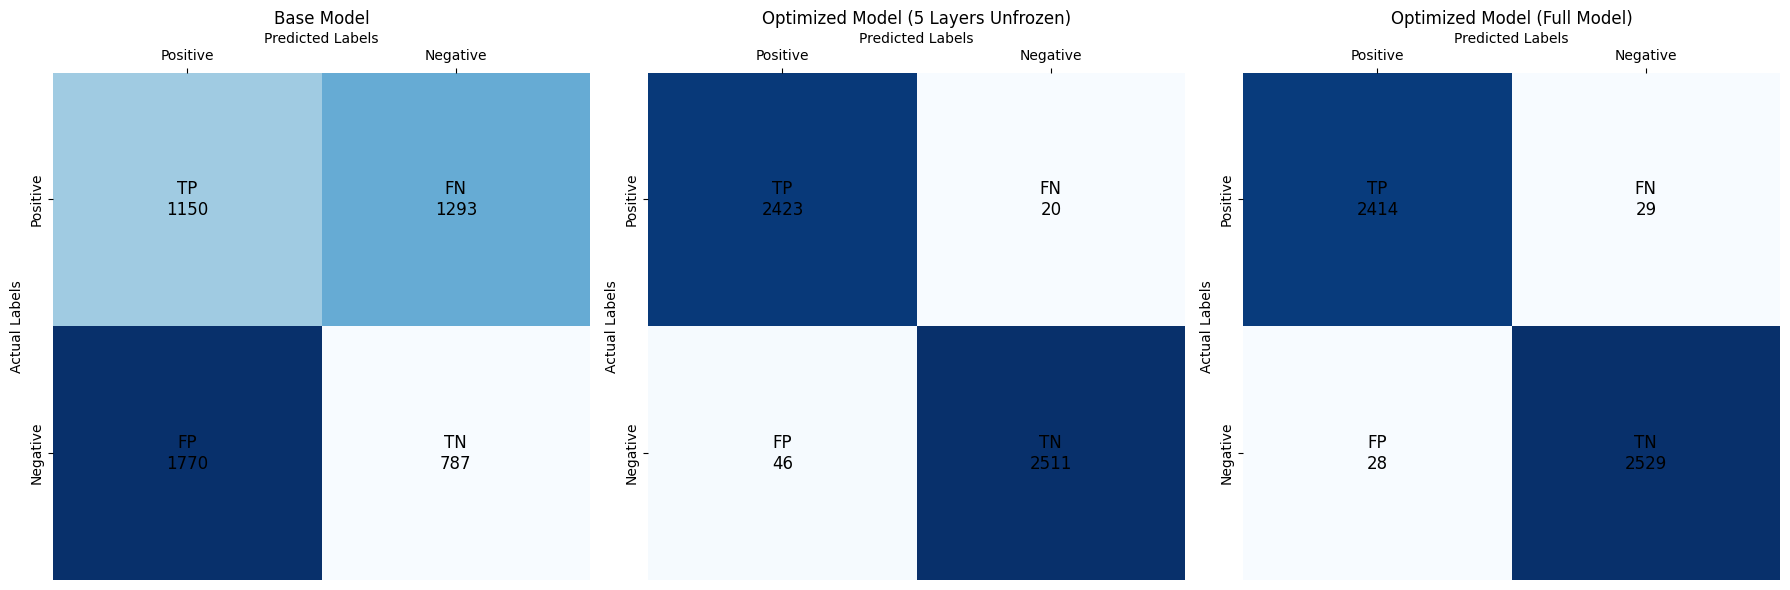

Model Comparison:
Base Model - Accuracy: 0.39, Precision: 0.38, Recall: 0.31
Optimized Model (5 Layers Unfrozen) - Accuracy: 0.99, Precision: 0.99, Recall: 0.98
Optimized Model (Full Model) - Accuracy: 0.99, Precision: 0.99, Recall: 0.99


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Assuming 'val_true_classes', 'val_predictions_classes', etc., are already defined

# Calculate confusion matrices for each model
confusion_base = confusion_matrix(val_true_classes, val_predictions_classes)
confusion_5_layers = confusion_matrix(val_true_classes_op, val_predictions_classes_op)
confusion_full_model = confusion_matrix(val_true_classes_op3, val_predictions_classes_op3)

# Calculate accuracy, precision, and recall for each model
accuracy_base = accuracy_score(val_true_classes, val_predictions_classes)
precision_base = precision_score(val_true_classes, val_predictions_classes)
recall_base = recall_score(val_true_classes, val_predictions_classes)

accuracy_5_layers = accuracy_score(val_true_classes_op, val_predictions_classes_op)
precision_5_layers = precision_score(val_true_classes_op, val_predictions_classes_op)
recall_5_layers = recall_score(val_true_classes_op, val_predictions_classes_op)

accuracy_full_model = accuracy_score(val_true_classes_op3, val_predictions_classes_op3)
precision_full_model = precision_score(val_true_classes_op3, val_predictions_classes_op3)
recall_full_model = recall_score(val_true_classes_op3, val_predictions_classes_op3)

# Create subplots to display confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the confusion matrix labels
labels = [["TP", "FN"], ["FP", "TN"]]

# Function to plot a confusion matrix
def plot_confusion_matrix(ax, confusion, title):
    sns.heatmap(confusion, annot=False, cmap='Blues',
                xticklabels=['Positive', 'Negative'],  # Predicted classes
                yticklabels=['Positive', 'Negative'],  # Actual classes
                cbar=False, ax=ax)

    # Add text annotations for TP, FP, FN, TN
    for i in range(2):
        for j in range(2):
            value = confusion[i, j]
            label = labels[i][j]
            ax.text(j + 0.5, i + 0.5, f"{label}\n{value}",
                    ha='center', va='center', color="black", fontsize=12)

    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

# Plot confusion matrices
plot_confusion_matrix(axes[0], confusion_base, 'Base Model')
plot_confusion_matrix(axes[1], confusion_5_layers, 'Optimized Model (5 Layers Unfrozen)')
plot_confusion_matrix(axes[2], confusion_full_model, 'Optimized Model (Full Model)')

# Adjust the layout
plt.tight_layout()
plt.show()

# Print Accuracy, Precision, and Recall for each model
print("Model Comparison:")
print(f"Base Model - Accuracy: {accuracy_base:.2f}, Precision: {precision_base:.2f}, Recall: {recall_base:.2f}")
print(f"Optimized Model (5 Layers Unfrozen) - Accuracy: {accuracy_5_layers:.2f}, Precision: {precision_5_layers:.2f}, Recall: {recall_5_layers:.2f}")
print(f"Optimized Model (Full Model) - Accuracy: {accuracy_full_model:.2f}, Precision: {precision_full_model:.2f}, Recall: {recall_full_model:.2f}")
